In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from smt.surrogate_models import KRG
from juliacall import Main as jl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm  # Colormap module

# import plotly.graph_objs as go

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [37]:
### CREATE DATA ARRAY ###

# Load the Julia file
jl.include("c:/Users/wongj_rl8z6/FlowLab/XFoil/write_xfoil.jl")

# Potential families of files to choose from
one_file = ["naca0012.dat"]
camber_files = ["naca0012.dat", "naca2412.dat", "naca4412.dat", "naca6412.dat"]
thickness_files = ["naca0009.dat", "naca0012.dat", "naca0015.dat", "naca0018.dat"]
test_camber_files = ["naca2412.dat"]
# Select which files to use
list_of_files =  camber_files

# Set parameters
alpha = np.arange(-16, 22, 2)  # range of angle of attacks, in degrees
re = 1e5

# Convert Python list to Julia array
julia_list_of_files = jl.convert(jl.Array, list_of_files)
julia_alpha = jl.convert(jl.Array, [float(a) for a in alpha])

# Get data from julia
julia_data = jl.process_files(julia_list_of_files, julia_alpha, re)

# Create numpy array from julia data, make sure type is float
data_array = np.array(julia_data, dtype=float)

columns = {
    "alpha": 0,
    "c_l": 1,
    "c_d": 2,
    "c_dp": 3,
    "c_m": 4,
    "converged": 5,
    "camber": 6,
    "thickness": 7
}

# Access data using column names
alpha_values = data_array[:, columns["alpha"]]
c_l_values = data_array[:, columns["c_l"]]
c_d_values = data_array[:, columns["c_d"]]
c_dp_values = data_array[:, columns["c_dp"]]
c_m_values = data_array[:, columns["c_m"]]
converged_values = data_array[:, columns["converged"]]
camber_values = data_array[:, columns["camber"]]
thickness_values = data_array[:, columns["thickness"]]

print(camber_values)
    

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.
 4. 4. 4. 4. 4. 4. 4. 4. 4. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6. 6.
 6. 6. 6. 6.]


___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 76
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  3.9349368
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0250118
   
   Prediction time/pt. (sec) :  0.0000100
   


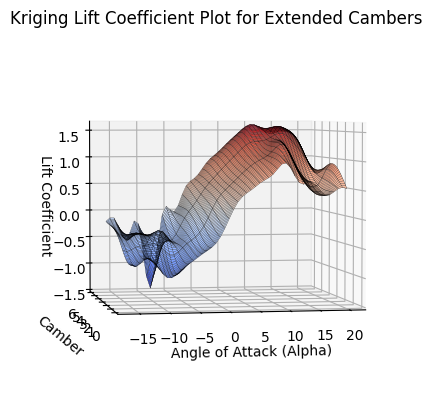

In [45]:
### CHOOSE LIFT, DRAG, OR MOMENT COEFFICIENT ###

# Choose which coefficient to plot
focus = "lift"  # "lift", "drag", or "moment"

# Create inputs (xt) for alpha and camber plot # attempt thickness
xt = np.column_stack((alpha_values, camber_values))

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


alpha_min = min(alpha_values)
alpha_max = max(alpha_values)
camber_min = min(camber_values)
camber_max = max(camber_values)
thickness_min = min(thickness_values)
thickness_max = max(thickness_values)

### CREATE MODEL ###

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha = np.linspace(alpha_min, alpha_max, 50)
# camber = np.linspace(camber_min, camber_max, 50)
# Create a custom camber array that includes the value 2
camber = np.linspace(camber_min, camber_max, 48)
camber = np.insert(camber, np.searchsorted(camber, 2), 2)
camber = np.insert(camber, np.searchsorted(camber, 4), 4)

alpha_grid, camber_grid = np.meshgrid(alpha, camber)
xt_grid = np.c_[alpha_grid.ravel(), camber_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

### PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, camber_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, camber_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'Kriging {zlabel} Plot for Extended Cambers')



# Change the camera angle
ax.view_init(elev=3, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

In [15]:
# Function to calculate MSE and plot as a bar plot
def plot_mse(ax, airfoil_name, alpha_masked, yt_masked, alpha_sorted, yt_sorted, idx, cmap, norm):
    # Interpolate the Kriging model predictions to match the alpha values of the data
    yt_interpolated = np.interp(alpha_masked, alpha_sorted, yt_sorted)

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((yt_masked - yt_interpolated) ** 2)
    print(f"Mean Squared Error (MSE) for {airfoil_name}: {mse}")

    # Plot the MSE as a bar plot
    ax.bar(airfoil_name, mse, color=cmap(norm(idx)), alpha=0.7)

naca0012
0
results_naca0012.dat
naca2412
2
results_naca2412.dat
naca4412
4
results_naca4412.dat
naca6412
6
results_naca6412.dat


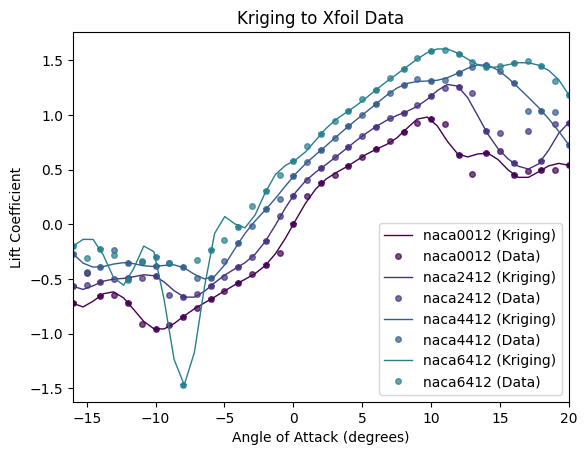

In [41]:
# Plot the family of curves
models = ["xxsmall", "xsmall", "small", "medium", "large", "xlarge", "xxlarge", "xxxlarge"]
cmap = cm.viridis #winter #inferno
norm = plt.Normalize(0, len(models) - 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig, ax1 = plt.subplots()
# fig, ax2 = plt.subplots()
# colors = plt.cm.viridis(np.linspace(0, 1, len(list_of_files)))  # Generate a list of colors

kriging_derivatives = {}  # Dictionary to store derivatives for each airfoil

# Function to compute numerical derivatives
def numerical_derivative(alpha, cl):
    return np.gradient(cl, alpha)

for idx, file in enumerate(list_of_files):
    # Extract the first digit of the airfoil's name
    first_digit = int(file[4])
    # create a label for the current file as naca0012, naca2412, etc.
    label = file.split('.')[0]
    print(label)
    print(first_digit)

    # Create a mask for the current file based on the first digit of the airfoil's name
    mask = (camber_values == first_digit)

    # Apply the mask to the alpha and yt values
    alpha_masked = alpha_values[mask]
    yt_masked = yt[mask]

    # Find the corresponding indices in the grid
    grid_mask = (camber_grid == first_digit)


    # Sort the masked values before plotting
    alpha_sorted = np.sort(alpha_grid[grid_mask])
    yt_sorted = yt_grid[grid_mask][np.argsort(alpha_grid[grid_mask])]

    # Plot the data for the current file
    ax1.plot(alpha_masked, yt_masked, '*', markersize=4, alpha=0.7, color=cmap(norm(idx)))
    ax1.plot(alpha_sorted, yt_sorted, '-', linewidth=1, label=f'{label} (Kriging)', color=cmap(norm(idx)))

    # Add data from results_airfoilname.dat to the plot
    results_file = "results_" + label + ".dat"
    print(results_file)
    results_data = np.loadtxt(results_file, skiprows=1)  # Skip header row
    alpha_data = results_data[:, 0]  # First column for alpha
    cl_data = results_data[:, 1]  # Second column for CL
    ax1.plot(alpha_data, cl_data, linestyle="", marker='o', markersize=4, color=cmap(norm(idx)), label=f"{label} (Data)", alpha = 0.7)

    # Call the function to calculate MSE and plot as a bar plot
    # plot_mse(ax2, label, alpha_masked, yt_masked, alpha_sorted, yt_sorted, idx, cmap, norm)

    # Create xt_masked for derivatives calculation
    xt_masked = np.column_stack((alpha_masked, np.full_like(alpha_masked, first_digit)))

    # derivatives = model.predict_derivatives(xt_masked, 0)  # 0 indicates derivatives with respect to the first input variable (alpha)
    derivatives = numerical_derivative(alpha_masked, yt_masked)  # Calculate numerical derivatives
    kriging_derivatives[label] = derivatives


plt.xlabel('Angle of Attack (degrees)')
plt.ylabel("Lift Coefficient" if focus == "lift" else "Drag Coefficient" if focus == "drag" else "Moment Coefficient")
plt.title(f'Kriging to Xfoil Data')
plt.xlim(-16, 20)
plt.legend()
plt.show()

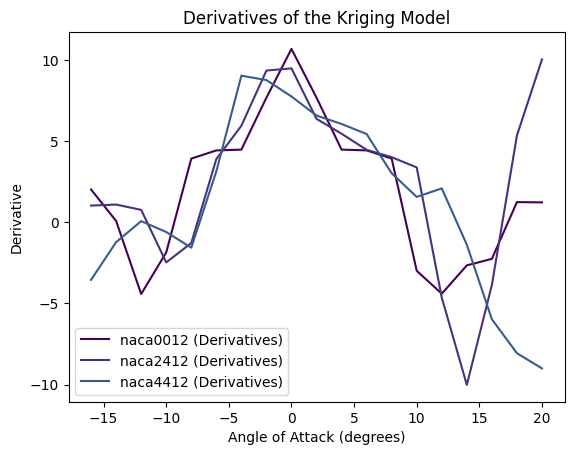

In [30]:
# Plot the derivatives - predict
fig, ax3 = plt.subplots()

for idx, (label, derivatives) in enumerate(kriging_derivatives.items()):
    ax3.plot(alpha_masked, derivatives*(180/np.pi), label=f'{label} (Derivatives)', color=cmap(norm(idx)))

# Add labels, title, and legend to the derivatives plot
ax3.set_xlabel('Angle of Attack (degrees)')
ax3.set_ylabel('Derivative')
ax3.set_title('Derivatives of the Kriging Model')
# ax3.set_ylim(-5, 5)
ax3.legend()

naca0012
0
results_naca0012.dat
naca2412
2
results_naca2412.dat
naca4412
4
results_naca4412.dat


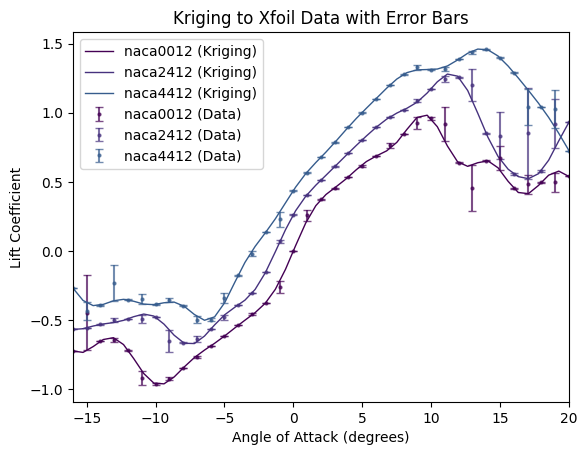

In [35]:
## PLOT WITH ERROR BARS ##

# Plot the family of curves
models = ["xxsmall", "xsmall", "small", "medium", "large", "xlarge", "xxlarge", "xxxlarge"]
cmap = cm.viridis  # winter # inferno
norm = plt.Normalize(0, len(models) - 1)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

fig, ax1 = plt.subplots()

kriging_derivatives = {}  # Dictionary to store derivatives for each airfoil

# Function to compute numerical derivatives
def numerical_derivative(alpha, cl):
    return np.gradient(cl, alpha)

for idx, file in enumerate(list_of_files):
    # Extract the first digit of the airfoil's name
    first_digit = int(file[4])
    # Create a label for the current file as naca0012, naca2412, etc.
    label = file.split('.')[0]
    print(label)
    print(first_digit)

    # Create a mask for the current file based on the first digit of the airfoil's name
    mask = (camber_values == first_digit)

    # Apply the mask to the alpha and yt values
    alpha_masked = alpha_values[mask]
    yt_masked = yt[mask]

    # Find the corresponding indices in the grid
    grid_mask = (camber_grid == first_digit)

    # Sort the masked values before plotting
    alpha_sorted = np.sort(alpha_grid[grid_mask])
    yt_sorted = yt_grid[grid_mask][np.argsort(alpha_grid[grid_mask])]

    # Plot the Kriging model predictions
    # ax1.plot(alpha_masked, yt_masked, '*', markersize=4, alpha=0.7, color=cmap(norm(idx)))
    ax1.plot(alpha_sorted, yt_sorted, '-', linewidth=1, label=f'{label} (Kriging)', color=cmap(norm(idx)))

    # Add data from results_airfoilname.dat to the plot
    results_file = "results_" + label + ".dat"
    print(results_file)
    results_data = np.loadtxt(results_file, skiprows=1)  # Skip header row
    alpha_data = results_data[:, 0]  # First column for alpha
    cl_data = results_data[:, 1]  # Second column for CL

    # Interpolate the Kriging model predictions to match the alpha_data points
    interpolated_cl = np.interp(alpha_data, alpha_sorted, yt_sorted)

    # Calculate the error between the data points and the Kriging model predictions
    error = np.abs(cl_data - interpolated_cl)  # Absolute error

    # Plot the data points with error bars
    ax1.errorbar(
        alpha_data,  # x-values (data points)
        cl_data,  # y-values (data points)
        yerr=error,  # Error bars (absolute error)
        fmt='o',  # Circular markers
        markersize=2,  # Very small markers
        color=cmap(norm(idx)),
        label=f"{label} (Data)", 
        capsize=3,  # Add caps to the error bars
        alpha=0.7   # Transparency for better visualization
    )

    # Compute numerical derivatives of the Kriging model at the given alpha values
    derivatives = numerical_derivative(alpha_masked, yt_masked)  # Calculate numerical derivatives
    kriging_derivatives[label] = derivatives

# Add labels, title, and legend
plt.xlabel('Angle of Attack (degrees)')
plt.ylabel("Lift Coefficient" if focus == "lift" else "Drag Coefficient" if focus == "drag" else "Moment Coefficient")
plt.title(f'Kriging to Xfoil Data with Error Bars')
plt.xlim(-16, 20)
plt.legend()
plt.show()

In [36]:
## Calculate MAE ##
# Initialize a list to store MAE for each airfoil
mae_list = []

# Loop through each airfoil
for idx, file in enumerate(list_of_files):
    # Extract the first digit of the airfoil's name
    first_digit = int(file[4])
    label = file.split('.')[0]  # Create a label for the current file (e.g., naca0012, naca2412, etc.)
    print(label)

    # Create a mask for the current file based on the first digit of the airfoil's name
    mask = (camber_values == first_digit)

    # Apply the mask to the alpha and yt values
    alpha_masked = alpha_values[mask]
    yt_masked = yt[mask]

    # Find the corresponding indices in the grid
    grid_mask = (camber_grid == first_digit)

    # Sort the masked values before plotting
    alpha_sorted = np.sort(alpha_grid[grid_mask])
    yt_sorted = yt_grid[grid_mask][np.argsort(alpha_grid[grid_mask])]

    # Load data points
    results_file = "results_" + label + ".dat"
    results_data = np.loadtxt(results_file, skiprows=1)  # Skip header row
    alpha_data = results_data[:, 0]  # First column for alpha
    cl_data = results_data[:, 1]  # Second column for CL

    # Interpolate the Kriging model predictions to match the alpha_data points
    interpolated_cl = np.interp(alpha_data, alpha_sorted, yt_sorted)

    # Calculate the absolute errors
    absolute_errors = np.abs(cl_data - interpolated_cl)

    # Compute Mean Absolute Error (MAE)
    mae = np.mean(absolute_errors)

    # Store the MAE
    mae_list.append(mae)

    # Print the MAE for the current airfoil
    print(f"Airfoil: {label}")
    print(f"  Mean Absolute Error (MAE): {mae:.6f}")

# Optionally, compute the overall MAE across all airfoils
overall_mae = np.mean(mae_list)

print("\nOverall Mean Absolute Error (MAE):")
print(f"  {overall_mae:.6f}")

naca0012
Airfoil: naca0012
  Mean Absolute Error (MAE): 0.042701
naca2412
Airfoil: naca2412
  Mean Absolute Error (MAE): 0.033337
naca4412
Airfoil: naca4412
  Mean Absolute Error (MAE): 0.031808

Overall Mean Absolute Error (MAE):
  0.035949


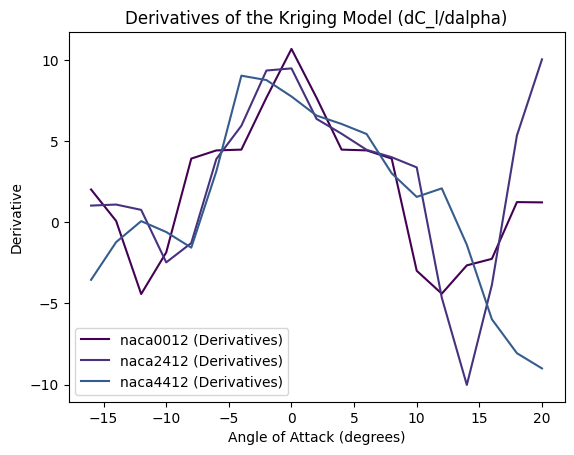

In [ ]:
# Plot the derivatives - numerical
fig, ax3 = plt.subplots()

for idx, (label, derivatives) in enumerate(kriging_derivatives.items()):
    ax3.plot(alpha_masked, derivatives*(180/np.pi), label=f'{label} (Derivatives)', color=cmap(norm(idx)))

# Add labels, title, and legend to the derivatives plot
ax3.set_xlabel('Angle of Attack (degrees)')
ax3.set_ylabel('Derivative')
ax3.set_title('Derivatives of the Kriging Model')
# ax3.set_ylim(-5, 5)
ax3.legend()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 76
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  2.3939884
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0153766
   
   Prediction time/pt. (sec) :  0.0000062
   


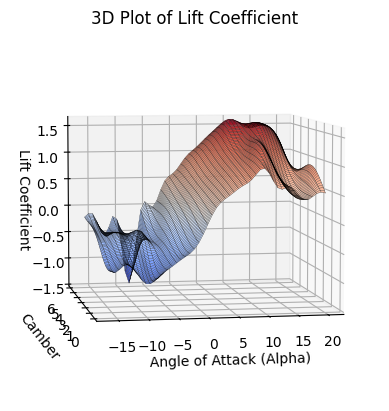

In [44]:
### CHOOSE DRAG COEFFICIENT ###

# Choose which coefficient to plot
focus = "lift"  # "lift", "drag", or "moment"

# Create inputs (xt) for alpha and camber plot # attempt thickness
xt = np.column_stack((alpha_values, camber_values))

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


alpha_min = min(alpha_values)
alpha_max = max(alpha_values)
camber_min = min(camber_values)
camber_max = max(camber_values)
thickness_min = min(thickness_values)
thickness_max = max(thickness_values)

### CREATE MODEL ###

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha = np.linspace(alpha_min, alpha_max, 50)
camber = np.linspace(camber_min, camber_max, 50)
alpha_grid, camber_grid = np.meshgrid(alpha, camber)
xt_grid = np.c_[alpha_grid.ravel(), camber_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

### PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, camber_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, camber_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=6, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 108
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  1.3616939
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0563557
   
   Prediction time/pt. (sec) :  0.0000225
   


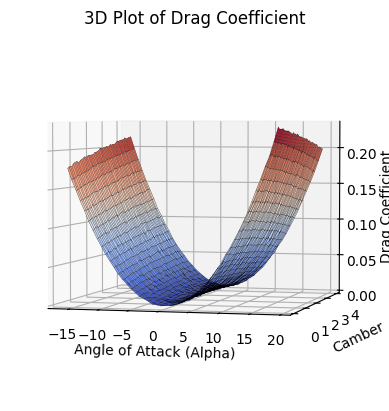

In [4]:
### CHOOSE DRAG COEFFICIENT ###

# Choose which coefficient to plot
focus = "drag"  # "lift", "drag", or "moment"

# Create inputs (xt) for alpha and camber plot # attempt thickness
xt = np.column_stack((alpha_values, camber_values))

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


alpha_min = min(alpha_values)
alpha_max = max(alpha_values)
camber_min = min(camber_values)
camber_max = max(camber_values)
thickness_min = min(thickness_values)
thickness_max = max(thickness_values)

### CREATE MODEL ###

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha = np.linspace(alpha_min, alpha_max, 50)
camber = np.linspace(camber_min, camber_max, 50)
alpha_grid, camber_grid = np.meshgrid(alpha, camber)
xt_grid = np.c_[alpha_grid.ravel(), camber_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

### PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, camber_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, camber_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=3, azim=285)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 108
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  1.7109897
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0237670
   
   Prediction time/pt. (sec) :  0.0000095
   


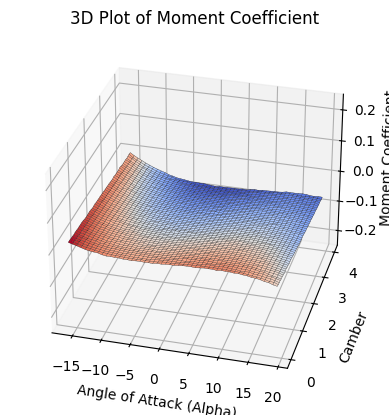

In [5]:
### CHOOSE MOMENT COEFFICIENT ###

# Choose which coefficient to plot
focus = "moment"  # "lift", "drag", or "moment"

# Create inputs (xt) for alpha and camber plot # attempt thickness
xt = np.column_stack((alpha_values, camber_values))

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


alpha_min = min(alpha_values)
alpha_max = max(alpha_values)
camber_min = min(camber_values)
camber_max = max(camber_values)
thickness_min = min(thickness_values)
thickness_max = max(thickness_values)

### CREATE MODEL ###

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()

# Create grid for prediction
alpha = np.linspace(alpha_min, alpha_max, 50)
camber = np.linspace(camber_min, camber_max, 50)
alpha_grid, camber_grid = np.meshgrid(alpha, camber)
xt_grid = np.c_[alpha_grid.ravel(), camber_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

### PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, camber_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, camber_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=30, azim=285)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

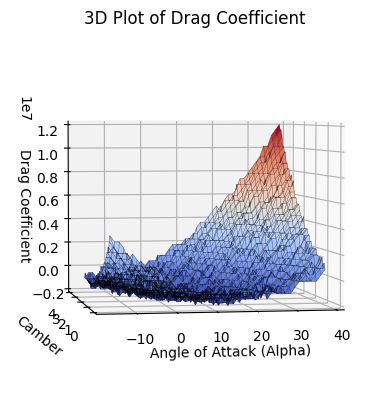

In [ ]:
### JUST PLOT MODEL W/O INTERACTIVE ###

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, camber_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, camber_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=3, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

In [ ]:
### CHOOSE LIFT, DRAG, OR MOMENT COEFFICIENT ### TRY WITH OTHER DIM

# Choose which coefficient to plot
focus = "lift"  # "lift", "drag", or "moment"

if focus == "lift":
    yt = c_l_values
    zlabel = "Lift Coefficient"
elif focus == "drag":
    yt = c_d_values
    zlabel = "Drag Coefficient"
elif focus == "moment":
    yt = c_m_values
    zlabel = "Moment Coefficient"


# Create inputs (xt) for alpha and camber plot
other_dim = "camber" # "camber" or "thickness"

if other_dim == "camber":
    second_dim = camber_values
elif other_dim == "thickness":
    second_dim = thickness_values

xt = np.column_stack((alpha_values, second_dim))
# print(xt)

[[-10.   0.]
 [ -8.   0.]
 [ -6.   0.]
 [ -4.   0.]
 [ -2.   0.]
 [  0.   0.]
 [  2.   0.]
 [  4.   0.]
 [  6.   0.]
 [  8.   0.]
 [ 10.   0.]
 [ 12.   0.]
 [ 14.   0.]
 [-10.   2.]
 [ -8.   2.]
 [ -6.   2.]
 [ -4.   2.]
 [ -2.   2.]
 [  0.   2.]
 [  2.   2.]
 [  4.   2.]
 [  6.   2.]
 [  8.   2.]
 [ 10.   2.]
 [ 12.   2.]
 [ 14.   2.]
 [-10.   4.]
 [ -8.   4.]
 [ -6.   4.]
 [ -4.   4.]
 [ -2.   4.]
 [  0.   4.]
 [  2.   4.]
 [  4.   4.]
 [  6.   4.]
 [  8.   4.]
 [ 10.   4.]
 [ 12.   4.]
 [ 14.   4.]]


In [ ]:
### CREATE MODEL ###  TRY SECOND DIM

# Create the surrogate model
model = KRG()
model.set_training_values(xt, yt)
model.train()
print(min(second_dim))
print(max(second_dim))

# Create grid for prediction
alpha = np.linspace(min(alpha_values), min(alpha_values), 50)
second_dim = np.linspace(min(second_dim), max(second_dim), 50)
alpha_grid, second_dim_grid = np.meshgrid(alpha, second_dim)
xt_grid = np.c_[alpha_grid.ravel(), second_dim_grid.ravel()]
yt_grid = model.predict_values(xt_grid).reshape(alpha_grid.shape)

___________________________________________________________________________
   
                                  Kriging
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 39
   
___________________________________________________________________________
   
 Training
   
   Training ...
   Training - done. Time (sec):  2.1276968
0.0
4.0
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 2500
   
   Predicting ...
   Predicting - done. Time (sec):  0.0181251
   
   Prediction time/pt. (sec) :  0.0000073
   


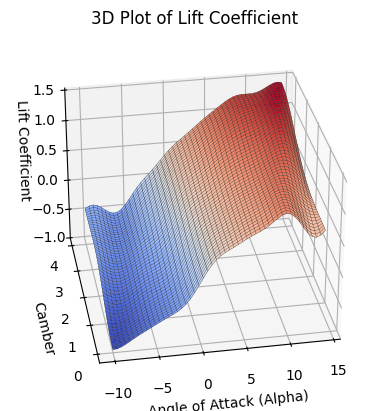

In [ ]:
### PLOT MODEL W/O INTERACTIVE ### copy

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, camber_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, camber_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=30, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

In [ ]:
### CREATE INTERACTIVE PLOTS ###

# Create the surface plot
surface = go.Surface(
    x=alpha_grid,
    y=camber_grid,
    z=yt_grid,
    colorscale='Viridis'
)

# Create the layout
layout = go.Layout(
    title='Interactive 3D Plot of Lift Coefficient',
    scene=dict(
        xaxis_title='Angle of Attack (Alpha)',
        yaxis_title='Camber',
        zaxis_title='Lift Coefficient'
    )
)

# Create the figure
fig = go.Figure(data=[surface], layout=layout)

# Show the plot
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

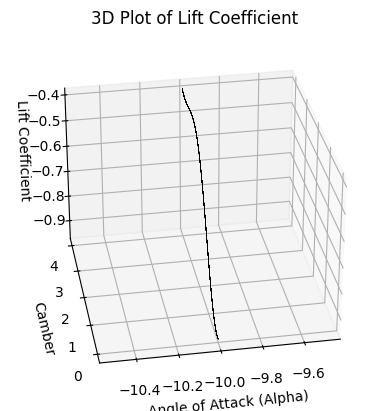

In [ ]:
### PLOT MODEL W/O INTERACTIVE ### with second_dim_grid

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

if focus == "moment":
    ax.set_zlim(-0.25, 0.25)

# Plot the surface
ax.plot_surface(alpha_grid, second_dim_grid, yt_grid, cmap='coolwarm')

# Plot the wireframe
ax.plot_wireframe(alpha_grid, second_dim_grid, yt_grid, color='black', linewidth=0.2)

ax.set_xlabel('Angle of Attack (Alpha)')
ax.set_ylabel('Camber')
ax.set_zlabel(zlabel)
ax.set_title(f'3D Plot of {zlabel}')



# Change the camera angle
ax.view_init(elev=30, azim=260)

# Save the figure
# plt.savefig('C:/Users/wongj_rl8z6/ME595R/NeuralFoilFigures/Moment_camber_3d.png', dpi=300)

plt.show()

In [40]:
### Code to write xfoil data to results_...dat file
def write_airfoil_results(input_file):
    # Load the Julia file
    jl.include("c:/Users/wongj_rl8z6/FlowLab/XFoil/write_xfoil.jl")

    # Define the range of angle of attacks and Reynolds number
    alpha = list(range(-20, 21, 1))  # Increase the range and density of angle of attacks
    re = 1e5

    # Convert Python list to Julia array
    julia_alpha = jl.convert(jl.Array, [float(a) for a in alpha])

    # Process the input file
    julia_list_of_files = jl.convert(jl.Array, [input_file])
    combined_data = jl.process_files(julia_list_of_files, julia_alpha, re)

    # Convert the combined data to a DataFrame with explicit column names
    columns = ["alpha", "c_l", "c_d", "c_dp", "c_m", "converged", "camber", "thickness"]
    data = pd.DataFrame(combined_data, columns=columns)

    # Extract the relevant data
    alpha_values = data["alpha"].values
    c_l_values = data["c_l"].values
    c_d_values = data["c_d"].values
    c_m_values = data["c_m"].values

    # Create the output file name
    output_file = f"results_{input_file}"

    # Write the data to the output file
    with open(output_file, 'w') as f:
        f.write("# Alpha    Lift Coefficient    Drag Coefficient    Moment Coefficient\n")
        for alpha, c_l, c_d, c_m in zip(alpha_values, c_l_values, c_d_values, c_m_values):
            f.write(f"{alpha:.2f}    {c_l:.6f}    {c_d:.6f}    {c_m:.6f}\n")

    print(f"Results written to {output_file}")

# Example usage
for file in ["naca6412.dat"]:
    write_airfoil_results(file)


Results written to results_naca6412.dat
